# N2V Prediction
Please run the ```01_N2VTraining.ipynb``` before.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import torch
from tifffile import imread
import sys
sys.path.append('../../../')
from unet.model import UNet
from pn2v.utils import denormalize
from pn2v.utils import normalize
from pn2v.utils import PSNR
from pn2v import utils
from pn2v import prediction
import pn2v.training
from pn2v import histNoiseModel

# See if we can use a GPU
device=utils.getDevice()

CUDA available? True


### Load Data

In [2]:
# We need the training data in order to calulate 'mean' and 'std' for normalization
path='../../../data/Mouse actin/'

# Load the test data
dataTest=imread(path+"sample_attempt2.tif")[:,:,:512] 
# We are loading only a sub image to spped up computation

# We estimate the ground truth by averaging.
dataTestGT=np.mean(dataTest[:,...],axis=0)[np.newaxis,...]


### Load the Network and Noise Model
Ensure that ```dataName``` is set same as in ```1_N2VTraining.ipynb```.

In [3]:
dataName = 'mouseactin' # Use the same name as used in N2VTraining.ipynb. This is a part of model name created in N2VTraining.ipynb 
nameModel=dataName+'_n2v'

### Load the Network

In [4]:
# Load the network, created in the '01_N2VTraining.ipynb' notebook
net=torch.load(path+"/last_"+nameModel+".net")

### Evaluation

image: 0
PSNR input 23.643400849264026
PSNR prior 33.366082979669486
PSNR mse 33.366082979669486
-----------------------------------
image: 1
PSNR input 23.620883803207068
PSNR prior 33.269492782811064
PSNR mse 33.269492782811064
-----------------------------------
image: 2
PSNR input 23.667113469021835
PSNR prior 33.28530028931871
PSNR mse 33.28530028931871
-----------------------------------
image: 3
PSNR input 23.64709110714436
PSNR prior 33.403052229930054
PSNR mse 33.403052229930054
-----------------------------------
image: 4
PSNR input 23.672914919463746
PSNR prior 33.378079813756855
PSNR mse 33.378079813756855
-----------------------------------
image: 5
PSNR input 23.669950605295924
PSNR prior 33.34578627458164
PSNR mse 33.34578627458164
-----------------------------------
image: 6
PSNR input 23.70231487515842
PSNR prior 33.308171575262186
PSNR mse 33.308171575262186
-----------------------------------
image: 7
PSNR input 23.705049534851174
PSNR prior 33.37959491997259
PSNR ms

image: 63
PSNR input 23.720689613627076
PSNR prior 33.357303270045506
PSNR mse 33.357303270045506
-----------------------------------
image: 64
PSNR input 23.716027075591573
PSNR prior 33.37785914758514
PSNR mse 33.37785914758514
-----------------------------------
image: 65
PSNR input 23.73440771063101
PSNR prior 33.41726215153232
PSNR mse 33.41726215153232
-----------------------------------
image: 66
PSNR input 23.752612512661457
PSNR prior 33.24249548138414
PSNR mse 33.24249548138414
-----------------------------------
image: 67
PSNR input 23.76459996947784
PSNR prior 33.37345016220796
PSNR mse 33.37345016220796
-----------------------------------
image: 68
PSNR input 23.759235163477868
PSNR prior 33.36032362674011
PSNR mse 33.36032362674011
-----------------------------------
image: 69
PSNR input 23.745309084966966
PSNR prior 33.377714317242464
PSNR mse 33.377714317242464
-----------------------------------
image: 70
PSNR input 23.7092400215346
PSNR prior 33.31103033160544
PSNR ms

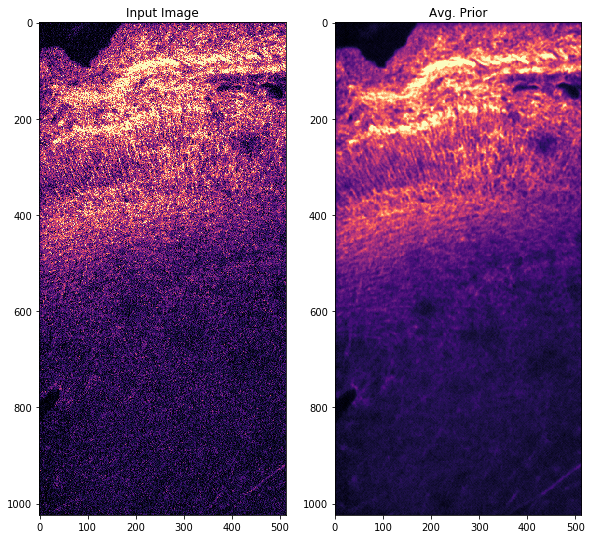

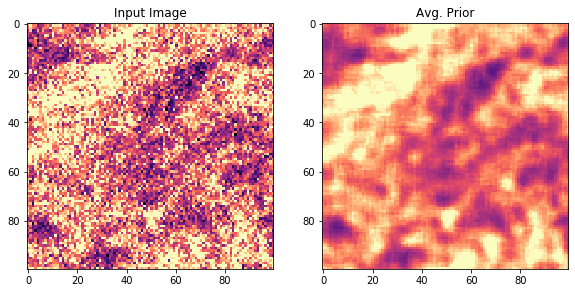

In [5]:
# Now we are processing data and calculating PSNR values.
results=[]
meanRes=[]
resultImgs=[]
inputImgs=[]

# We iterate over all test images.
for index in range(dataTest.shape[0]):
    
    im=dataTest[index]
    gt=dataTestGT[0] # The ground truth is the same for all images
    
    # We are using tiling to fit the image into memory
    # If you get an error try a smaller patch size (ps)
    
    means = prediction.tiledPredict(im, net ,ps=256, overlap=48,
                                            device=device, noiseModel=None)
    
    resultImgs.append(means)
    inputImgs.append(im)

    rangePSNR=np.max(gt)-np.min(gt)
    psnr=PSNR(gt, means,rangePSNR )
    psnrPrior=PSNR(gt, means,rangePSNR )
    results.append(psnr)
    meanRes.append(psnrPrior)

    print ("image:",index)
    print ("PSNR input",PSNR(gt, im, rangePSNR))
    print ("PSNR prior",psnrPrior) # Without info from masked pixel
    print ("PSNR mse",psnr) # MMSE estimate using the masked pixel
    print ('-----------------------------------')

    
    
    
# We display the results for the last test image       
vmi=np.percentile(gt,0.01)
vma=np.percentile(gt,99)

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title(label='Input Image')
plt.imshow(im, vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 2)
plt.title(label='Avg. Prior')
plt.imshow(means, vmax=vma, vmin=vmi, cmap='magma')

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title(label='Input Image')
plt.imshow(im[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 2)
plt.title(label='Avg. Prior')
plt.imshow(means[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')

print("Avg PSNR Prior:", np.mean(np.array(meanRes) ), '+-(2SEM)',2*np.std(np.array(meanRes) )/np.sqrt(float(len(meanRes)) ) )
print("Avg PSNR MMSE:", np.mean(np.array(results) ),  '+-(2SEM)' ,2*np.std(np.array(results) )/np.sqrt(float(len(results)) ) )